# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [1]:
import h2o
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.remove_all()
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp1s1_aa81
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp1s1_aa81/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp1s1_aa81/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.11.0.3898
H2O cluster version age:,16 hours and 33 minutes
H2O cluster name:,H2O_from_python_phall_2vubt0
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## Import data

In [2]:
train = h2o.import_file('../data/train.csv')
test = h2o.import_file('../data/test.csv')

#### Determine data types

In [3]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists()

Numeric = ['BsmtUnfSF', 'BsmtFinSF1', 'LotFrontage', '2ndFlrSF', 'OverallQual', 'KitchenAbvGr', 'MoSold', 'HalfBath', 'GarageCars', 'MSSubClass', 'OpenPorchSF', 'GrLivArea', 'FullBath', 'YearRemodAdd', 'MiscVal', 'MasVnrArea', 'BsmtFullBath', 'OverallCond', '1stFlrSF', 'ScreenPorch', 'TotRmsAbvGrd', 'BsmtFinSF2', 'TotalBsmtSF', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'PoolArea', 'YrSold', 'LotArea', 'YearBuilt', 'BsmtHalfBath', 'BedroomAbvGr', 'GarageYrBlt', 'LowQualFinSF', 'Fireplaces', 'GarageArea']

Categorical = ['BsmtCond', 'FireplaceQu', 'ExterCond', 'RoofMatl', 'Alley', 'LandContour', 'HeatingQC', 'BsmtQual', 'PoolQC', 'LotConfig', 'Condition1', 'LandSlope', 'BsmtFinType2', 'GarageQual', 'Exterior2nd', 'Functional', 'Neighborhood', 'Condition2', 'RoofStyle', 'HouseStyle', 'SaleCondition', 'SaleType', 'Electrical', 'GarageFinish', 'Heating', 'BsmtFinType1', 'Exterior1st', 'BsmtExposure', 'MSZoning', 'Street', 'KitchenQual', 'GarageType', 'ExterQual', 'Utilities', 'BldgType', 

## Impute numeric missing

In [5]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [6]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):
    
    """ Applies simple target encoding to categorical variables.
    
    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames. 
    
    """
    
    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series

    
    # create dictionary of level:encode val
    
    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)
                
    row_val_dict[np.nan] = overall_mean # handle missing values
    
    if test:
        print(row_val_dict)
        
    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])   
    
    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])
    
    # convert back to H2O
    
    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]
    
    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]
    
    return (trdf, tsdf)


#### Execute encoding

In [7]:
for i, var in enumerate(cats):
    
    total = len(cats)
    tr_enc, ts_enc = target_encoder(train, test, var, 'SalePrice')

    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: BsmtCond (1/43) ...
Encoding: FireplaceQu (2/43) ...
Encoding: ExterCond (3/43) ...
Encoding: RoofMatl (4/43) ...
Encoding: Alley (5/43) ...
Encoding: LandContour (6/43) ...
Encoding: HeatingQC (7/43) ...
Encoding: BsmtQual (8/43) ...
Encoding: PoolQC (9/43) ...
Encoding: LotConfig (10/43) ...
Encoding: Condition1 (11/43) ...
Encoding: LandSlope (12/43) ...
Encoding: BsmtFinType2 (13/43) ...
Encoding: GarageQual (14/43) ...
Encoding: Exterior2nd (15/43) ...
Encoding: Functional (16/43) ...
Encoding: Neighborhood (17/43) ...
Encoding: Condition2 (18/43) ...
Encoding: RoofStyle (19/43) ...
Encoding: HouseStyle (20/43) ...
Encoding: SaleCondition (21/43) ...
Encoding: SaleType (22/43) ...
Encoding: Electrical (23/43) ...
Encoding: GarageFinish (24/43) ...
Encoding: Heating (25/43) ...
Encoding: BsmtFinType1 (26/43) ...
Encoding: Exterior1st (27/43) ...
Encoding: BsmtExposure (28/43) ...
Encoding: MSZoning (29/43) ...
Encoding: Street (30/43) ...
Encoding: KitchenQual (31/43) ...

#### Redefine numerics and explore

In [8]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['BsmtUnfSF', 'Exterior1st_Tencode', 'BsmtFinSF1', 'PoolQC_Tencode', 'LotFrontage', 'GarageCond_Tencode', 'Utilities_Tencode', '2ndFlrSF', 'ExterQual_Tencode', 'Condition2_Tencode', 'LotConfig_Tencode', 'Heating_Tencode', 'KitchenAbvGr', 'Functional_Tencode', 'BldgType_Tencode', 'MoSold', 'HalfBath', 'LotShape_Tencode', 'GarageCars', 'MSSubClass', 'OpenPorchSF', 'GrLivArea', 'FullBath', 'Foundation_Tencode', 'YearRemodAdd', 'MiscVal', 'HeatingQC_Tencode', 'RoofMatl_Tencode', 'GarageFinish_Tencode', 'MSZoning_Tencode', 'BsmtFullBath', 'Exterior2nd_Tencode', 'SaleType_Tencode', 'OverallQual', 'OverallCond', '1stFlrSF', 'RoofStyle_Tencode', 'ScreenPorch', 'Alley_Tencode', 'TotRmsAbvGrd', 'Electrical_Tencode', 'FireplaceQu_Tencode', 'KitchenQual_Tencode', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtFinType1_Tencode', 'WoodDeckSF', 'Neighborhood_Tencode', 'EnclosedPorch', 'GarageYrBlt', '3SsnPorch', 'BsmtExposure_Tencode', 'BsmtFinType2_Tencode', 'MasVnrType_Tencode', 'SaleCondition_Tencode

In [9]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1460
Cols:79




,BsmtUnfSF,Exterior1st_Tencode,BsmtFinSF1,PoolQC_Tencode,LotFrontage,GarageCond_Tencode,Utilities_Tencode,2ndFlrSF,ExterQual_Tencode,Condition2_Tencode,LotConfig_Tencode,Heating_Tencode,KitchenAbvGr,Functional_Tencode,BldgType_Tencode,MoSold,HalfBath,LotShape_Tencode,GarageCars,MSSubClass,OpenPorchSF,GrLivArea,FullBath,Foundation_Tencode,YearRemodAdd,MiscVal,HeatingQC_Tencode,RoofMatl_Tencode,GarageFinish_Tencode,MSZoning_Tencode,BsmtFullBath,Exterior2nd_Tencode,SaleType_Tencode,OverallQual,OverallCond,1stFlrSF,RoofStyle_Tencode,ScreenPorch,Alley_Tencode,TotRmsAbvGrd,Electrical_Tencode,FireplaceQu_Tencode,KitchenQual_Tencode,BsmtFinSF2,TotalBsmtSF,BsmtFinType1_Tencode,WoodDeckSF,Neighborhood_Tencode,EnclosedPorch,GarageYrBlt,3SsnPorch,BsmtExposure_Tencode,BsmtFinType2_Tencode,MasVnrType_Tencode,SaleCondition_Tencode,MasVnrArea,MiscFeature_Tencode,BsmtQual_Tencode,Fence_Tencode,LandContour_Tencode,HouseStyle_Tencode,Condition1_Tencode,PoolArea,YrSold,LotArea,YearBuilt,BsmtHalfBath,BedroomAbvGr,GarageType_Tencode,PavedDrive_Tencode,LowQualFinSF,Fireplaces,GarageArea,ExterCond_Tencode,BsmtCond_Tencode,GarageQual_Tencode,CentralAir_Tencode,LandSlope_Tencode,Street_Tencode
type,int,real,int,real,real,real,real,int,real,real,real,real,int,real,real,int,int,real,int,int,int,int,int,real,int,int,real,real,real,real,int,real,real,int,int,int,real,int,real,int,real,real,real,int,int,real,int,real,int,real,int,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,int,int,real,real,int,int,int,real,real,real,real,real,real
mins,0.0,87488.17938356164,0.0,180921.19589041095,21.0,119363.17938356163,144013.17938356166,0.0,101925.61152641877,109375.67938356163,176938.0475285171,88763.17938356164,0.0,100068.17938356164,136305.59873840035,1.0,0.0,164754.81837837838,0.0,20.0,0.0,334.0,0.0,118398.96063356163,1950.0,0.0,101088.17938356164,143588.17938356166,142156.42314049587,90486.97938356163,0.0,116388.17938356163,129010.67938356163,1.0,1.0,334.0,153710.9066562889,0.0,131024.39738356163,2.0,84088.17938356164,137437.70688356162,116868.60374253601,0.0,0.0,151994.04028581732,0.0,110928.17938356163,0.0,1900.0,0.0,165652.29590766,155574.02938356163,151508.53605022831,115644.42938356163,0.0,107038.17938356163,125476.40366927591,141281.58847447074,148776.6468438791,120765.67938356163,141966.09605022828,0.0,2006.0,1300.0,1872.0,0.0,0.0,120605.97382800607,124921.43327245054,0.0,0.0,0.0,92163.17938356164,81538.17938356164,112279.84605022831,116612.64201514059,179956.7995658466,137800.10438356164
mean,567.2404109589041,180880.5669704916,443.6397260273973,181358.14341400826,70.04995836802664,185529.6042633233,180925.6569721805,346.99246575342465,180058.82286939386,180958.04482243385,180509.66312370988,181082.57937689996,1.0465753424657533,181271.62194407952,181528.18075483205,6.321917808219178,0.38287671232876713,180636.96109490524,1.7671232876712328,56.897260273972606,46.66027397260274,1515.463698630137,1.5650684931506849,181839.7781230531,1984.8657534246574,43.489041095890414,181217.80597203973,180756.55353696752,185226.61840213925,180890.65145472885,0.42534246575342466,181031.77015866013,179942.3916239914,6.0993150684931505,5.575342465753424,1162.626712328767,180930.1805271627,15.060958904109588,178903.9882177238,6.517808219178082,181738.1697731751,199396.0979636423,179706.3537221336,46.54931506849315,1057.4294520547944,183992.5769034997,94.2445205479452,180373.08053504408,21.954109589041096,1978.5061638868744,3.4095890410958902,181624.85937051979,182969.4818640458,179556.69860888534,180217.29174554325,103.68526170798899,180000.13846481516,181246.74738478137,175820.09948517545,180821.86755352785,181286.7320662882,181383.89587446052,2.758904109589041,2007.8157534246575,10516.828082191782,1971.267808219178,0.057534246575342465,2.8664383561643834,184682.71746706698,181680.14683289544,5.844520547945206,0.613013698630137,472.9801369863014,181331.30861662602,182907.7643074686,185465.54685972977,181659.6301311222,180784.26482323135,180952.468237

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,BsmtUnfSF,Exterior1st_Tencode,BsmtFinSF1,PoolQC_Tencode,LotFrontage,GarageCond_Tencode,Utilities_Tencode,2ndFlrSF,ExterQual_Tencode,Condition2_Tencode,LotConfig_Tencode,Heating_Tencode,KitchenAbvGr,Functional_Tencode,BldgType_Tencode,MoSold,HalfBath,LotShape_Tencode,GarageCars,MSSubClass,OpenPorchSF,GrLivArea,FullBath,Foundation_Tencode,YearRemodAdd,MiscVal,HeatingQC_Tencode,RoofMatl_Tencode,GarageFinish_Tencode,MSZoning_Tencode,BsmtFullBath,Exterior2nd_Tencode,SaleType_Tencode,OverallQual,OverallCond,1stFlrSF,RoofStyle_Tencode,ScreenPorch,Alley_Tencode,TotRmsAbvGrd,Electrical_Tencode,FireplaceQu_Tencode,KitchenQual_Tencode,BsmtFinSF2,TotalBsmtSF,BsmtFinType1_Tencode,WoodDeckSF,Neighborhood_Tencode,EnclosedPorch,GarageYrBlt,3SsnPorch,BsmtExposure_Tencode,BsmtFinType2_Tencode,MasVnrType_Tencode,SaleCondition_Tencode,MasVnrArea,MiscFeature_Tencode,BsmtQual_Tencode,Fence_Tencode,LandContour_Tencode,HouseStyle_Tencode,Condition1_Tencode,PoolArea,YrSold,LotArea,YearBuilt,BsmtHalfBath,BedroomAbvGr,GarageType_Tencode,PavedDrive_Tencode,LowQualFinSF,Fireplaces,GarageArea,ExterCond_Tencode,BsmtCond_Tencode,GarageQual_Tencode,CentralAir_Tencode,LandSlope_Tencode,Street_Tencode
type,real,real,real,real,real,real,real,int,real,real,real,real,int,real,real,int,int,real,real,int,int,int,int,real,int,int,real,real,real,real,real,real,real,int,int,int,real,int,real,int,real,real,real,real,real,real,int,real,int,real,int,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,real,int,real,real,int,int,real,real,real,real,real,real,real
mins,0.0,87488.17938356164,0.0,180921.19589041095,21.0,119363.17938356163,180921.19589041095,0.0,101925.61152641877,117663.17938356163,176938.0475285171,91118.89366927592,0.0,100068.17938356164,136305.59873840035,1.0,0.0,164754.81837837838,0.0,20.0,0.0,407.0,0.0,118398.96063356163,1950.0,0.0,101088.17938356164,179803.6792189679,142156.42314049587,90486.97938356163,0.0,116388.17938356163,129010.67938356163,1.0,1.0,407.0,153710.9066562889,0.0,131024.39738356163,3.0,109871.51271689495,137437.70688356162,116868.60374253601,0.0,0.0,151994.04028581732,0.0,110928.17938356163,0.0,1895.0,0.0,165652.29590766,155574.02938356163,151508.53605022831,115644.42938356163,0.0,107038.17938356163,125476.40366927591,141281.58847447074,148776.6468438791,120765.67938356163,141966.09605022828,0.0,2006.0,1470.0,1879.0,0.0,0.0,120605.97382800607,124921.43327245054,0.0,0.0,0.0,92163.17938356164,81538.17938356164,112279.84605022831,116612.64201514059,179956.7995658466,137800.10438356164
mean,554.2949245541838,180163.89739622173,439.2037037037037,181293.60332733998,68.58035714285714,185422.7774534009,180950.9160234005,325.9677861549006,180460.36175619633,181166.03732137335,180234.81382594892,181709.8782401401,1.0424948594928032,181323.9571258677,181077.96729000125,6.104180945853324,0.3776559287183002,180249.28067462493,1.7661179698216736,57.37834132967786,48.3139136394791,1486.0459218642907,1.570938999314599,182394.1607868111,1983.6627827278958,58.16792323509253,181724.34342026233,180110.94715035174,184827.78985491671,179772.8336670903,0.4344543582704186,180766.37959959693,179613.55995767802,6.078821110349555,5.5538039753255655,1156.534612748458,180180.92858796637,17.064427690198766,178248.7290662322,6.385195339273475,181890.53298830043,197633.5311456587,179420.17532378223,52.61934156378601,1046.1179698216736,184645.88361245434,93.17477724468814,178691.2305139906,24.24331734064427,1977.7212165097756,1.794379712131597,181657.00791990335,183200.1159337163,178895.07396658702,179879.1401656116,100.70914127423823,180005.30438727606,181935.06349994175,175663.07479793802,181450.84022501088,180645.5075029316,181389.31663321095,1.7443454420836186,2007.7697052775875,9819.161069225496,1971.357779300891,0.06520247083047358,2.8540095956134337,184656.7295734541,180094.9269028509,3.5435229609321452,0.5812200137080192,472.7688614540466,180735.6325431525,182176.8367729062,184312.7546957362,181370.41046901883,180592.19026393845,180952.346187

In [10]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(train, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   145847
# NAmes   145847
# Gilbert 191064
# Gilbert 191064
# StoneBr 291062

Neighborhood,Neighborhood_Tencode
NAmes,145847
NAmes,145847
Gilbert,191065
Gilbert,191065
StoneBr,291062



{nan: 180921.19589041095, 'Gilbert': 191064.5097633085, 'NPkVill': 148428.4571613394, 'StoneBr': 291062.3293835616, 'Veenker': 230094.99756537983, 'SWISU': 148340.8353835616, 'SawyerW': 185710.60650220572, 'Blueste': 144013.17938356166, 'OldTown': 136129.68513577402, 'CollgCr': 197965.77333333335, 'NridgHt': 295968.20925369154, 'Timber': 233048.5096467195, 'BrkSide': 133247.12334907887, 'BrDale': 115957.86688356164, 'Somerst': 218711.04101146862, 'NAmes': 145847.08, 'Edwards': 136124.92438356165, 'Sawyer': 143412.3442484265, 'MeadowV': 110928.17938356164, 'NoRidge': 312139.1988957568, 'Crawfor': 206169.19605022832, 'Mitchel': 159967.78346519428, 'ClearCr': 207818.79366927594, 'Blmngtn': 192778.42938356166, 'NWAmes': 187830.7376027397, 'IDOTRR': 112243.39559977785}


## Create combination features

In [11]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [12]:
train, test = feature_combiner(train, test, encoded_nums)

Combining: BsmtUnfSF (1/79) ...
Combining: Exterior1st_Tencode (2/79) ...
Combining: BsmtFinSF1 (3/79) ...
Combining: PoolQC_Tencode (4/79) ...
Combining: LotFrontage (5/79) ...
Combining: GarageCond_Tencode (6/79) ...
Combining: Utilities_Tencode (7/79) ...
Combining: 2ndFlrSF (8/79) ...
Combining: ExterQual_Tencode (9/79) ...
Combining: Condition2_Tencode (10/79) ...
Combining: LotConfig_Tencode (11/79) ...
Combining: Heating_Tencode (12/79) ...
Combining: KitchenAbvGr (13/79) ...
Combining: Functional_Tencode (14/79) ...
Combining: BldgType_Tencode (15/79) ...
Combining: MoSold (16/79) ...
Combining: HalfBath (17/79) ...
Combining: LotShape_Tencode (18/79) ...
Combining: GarageCars (19/79) ...
Combining: MSSubClass (20/79) ...
Combining: OpenPorchSF (21/79) ...
Combining: GrLivArea (22/79) ...
Combining: FullBath (23/79) ...
Combining: Foundation_Tencode (24/79) ...
Combining: YearRemodAdd (25/79) ...
Combining: MiscVal (26/79) ...
Combining: HeatingQC_Tencode (27/79) ...
Combining:

#### Redefine numerics and explore

In [13]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['RoofMatl_Tencode|GarageQual_Tencode', 'BsmtQual_Tencode|GarageArea', 'Exterior2nd_Tencode|TotRmsAbvGrd', 'HeatingQC_Tencode|Fence_Tencode', 'PoolQC_Tencode|3SsnPorch', 'BsmtUnfSF|Neighborhood_Tencode', 'MoSold|SaleType_Tencode', 'Condition2_Tencode|Functional_Tencode', 'RoofStyle_Tencode|GarageType_Tencode', 'RoofMatl_Tencode|WoodDeckSF', 'BsmtFullBath|MiscFeature_Tencode', 'KitchenQual_Tencode|BsmtExposure_Tencode', 'RoofStyle_Tencode|GarageQual_Tencode', 'HalfBath|BsmtFinType1_Tencode', 'RoofMatl_Tencode|SaleType_Tencode', 'YrSold|YearBuilt', 'OverallQual|BsmtHalfBath', 'GarageYrBlt|BsmtQual_Tencode', 'LotShape_Tencode|FullBath', 'YearRemodAdd|BsmtCond_Tencode', 'HeatingQC_Tencode|Exterior2nd_Tencode', 'Functional_Tencode|BsmtExposure_Tencode', 'PoolQC_Tencode|Alley_Tencode', 'FireplaceQu_Tencode|Neighborhood_Tencode', 'BldgType_Tencode', 'YearRemodAdd', 'OpenPorchSF|Neighborhood_Tencode', 'Alley_Tencode|HouseStyle_Tencode', 'MasVnrType_Tencode|HouseStyle_Tencode', 'MiscV

In [14]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1460, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1))))

True
True


In [15]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

LandContour_Tencode,CentralAir_Tencode,LandContour_Tencode|CentralAir_Tencode
180184,116613,2.10117e+10


LandContour_Tencode,CentralAir_Tencode,LandContour_Tencode|CentralAir_Tencode
180184,186187,3.35478e+10



21011702757.660706
33547818984.581978


## Train constituent models (for inspection purposes)

In [16]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search

SalePrice
12.2477
12.109
12.3172


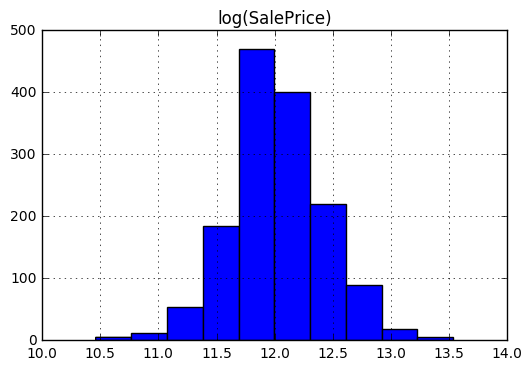

In [17]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [18]:
base_train, base_valid, stack_train, stack_valid = train.split_frame([0.3, 0.2, 0.3], seed=12345)
print(base_train.shape)
print(base_valid.shape)
print(stack_train.shape)
print(stack_valid.shape)

(441, 3205)
(297, 3205)
(425, 3205)
(297, 3205)


#### Define model with grid search function

In [19]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


## Train base level models

#### First model on original numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_1_model_1   
1     [0.5]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_1_model_2   
2    [0.99]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_1_model_3   
3    [0.01]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_1_model_0   

    residual_deviance  
0  6.1547872644675135  
1   6.176742787271307  
2    6.18777456413037  
3   6.222185404213095  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_1_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.030433677244580275
RMSE: 0.17445250713182736
MAE: 0.11944477286438474
RMSLE: 0.013420792192346001
R^2: 0.8278683153607944
Mean Residual Deviance: 0.030433677244580275
Null degrees of 

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-30 15:52:20,0.000 sec,0,.13E1,2,0.1715065,0.1442587
,2017-05-30 15:52:20,0.001 sec,0,.12E1,2,0.1663340,0.1395944
,2017-05-30 15:52:20,0.003 sec,0,.12E1,2,0.1612922,0.1350533
,2017-05-30 15:52:20,0.004 sec,0,.11E1,2,0.1563858,0.1306395
,2017-05-30 15:52:20,0.006 sec,0,.11E1,2,0.1516189,0.1263565
---,---,---,---,---,---,---,---
,2017-05-30 15:52:20,0.151 sec,0,.16E-1,26,0.0300759,0.0207583
,2017-05-30 15:52:20,0.153 sec,0,.16E-1,26,0.0300370,0.0207626
,2017-05-30 15:52:20,0.155 sec,0,.15E-1,26,0.0300004,0.0207676
,2017-05-30 15:52:20,0.156 sec,0,.14E-1,26,0.0299672,0.0207743



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2194
11.7745,12.1191
11.964,11.8372
12.6925,12.6562
11.9447,11.9856
12.1002,12.2708
12.6411,12.6413
11.8776,11.8451
11.7772,11.7651
12.428,12.3933


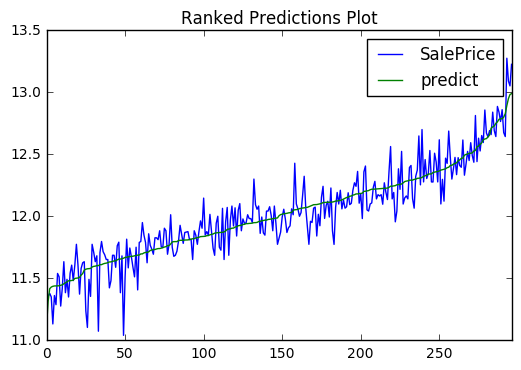

In [20]:
glm0 = glm_grid(original_nums, 'SalePrice', base_train, base_valid)

#### Second model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_2_model_1   
1     [0.5]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_2_model_2   
2    [0.99]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_2_model_3   
3    [0.01]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_2_model_0   

    residual_deviance  
0   4.775336206125794  
1   4.787030279517772  
2   4.793837886299324  
3  4.8354931931910246  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_2_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.019837420219256715
RMSE: 0.1408453769892953
MAE: 0.10072422824568843
RMSLE: 0.010889062505728658
R^2: 0.8878003294247135
Mean Residual Deviance: 0.019837420219256715
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-30 15:52:22,0.000 sec,0,.13E1,2,0.1715065,0.1442587
,2017-05-30 15:52:22,0.001 sec,0,.12E1,2,0.1663340,0.1395944
,2017-05-30 15:52:22,0.002 sec,0,.12E1,3,0.1602977,0.1341616
,2017-05-30 15:52:22,0.003 sec,0,.11E1,3,0.1536219,0.1281660
,2017-05-30 15:52:22,0.005 sec,0,.11E1,3,0.1472498,0.1224546
---,---,---,---,---,---,---,---
,2017-05-30 15:52:22,0.136 sec,0,.16E-1,58,0.0191643,0.0162253
,2017-05-30 15:52:22,0.139 sec,0,.16E-1,58,0.0190562,0.0162614
,2017-05-30 15:52:22,0.140 sec,0,.15E-1,60,0.0189517,0.0163117
,2017-05-30 15:52:22,0.142 sec,0,.14E-1,60,0.0188555,0.0163678



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.214
11.7745,11.8748
11.964,11.8278
12.6925,12.7864
11.9447,11.9575
12.1002,12.2235
12.6411,12.716
11.8776,11.9757
11.7772,11.9096
12.428,12.3596


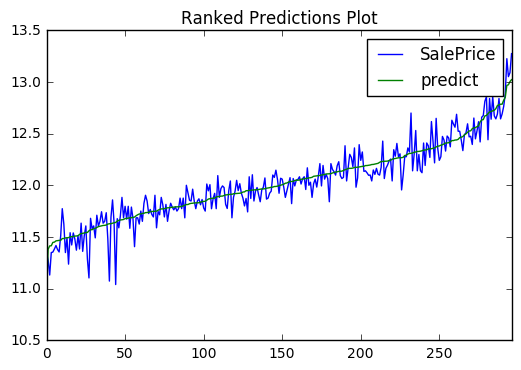

In [21]:
glm1 = glm_grid(encoded_nums, 'SalePrice', base_train, base_valid)

#### Third model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_3_model_0   
1     [0.5]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_3_model_2   
2    [0.25]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_3_model_1   
3    [0.99]  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_3_model_3   

   residual_deviance  
0  4.093218564561575  
1  4.154305186218854  
2  4.157420628478566  
3  4.178296781508378  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_bb40_model_python_1496184694009_3_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012605744851690396
RMSE: 0.1122753082903378
MAE: 0.08035289524642285
RMSLE: 0.008763861912179677
R^2: 0.9287024016185926
Mean Residual Deviance: 0.012605744851690396
Null degrees of freedo

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-30 15:52:23,0.000 sec,0,.33E2,29,0.1743066,0.1468120
,2017-05-30 15:52:23,0.033 sec,0,.32E2,45,0.1688062,0.1419206
,2017-05-30 15:52:23,0.068 sec,0,.3E2,68,0.1619426,0.1358364
,2017-05-30 15:52:23,0.107 sec,0,.29E2,94,0.1543404,0.1290885
,2017-05-30 15:52:23,0.156 sec,0,.28E2,114,0.1464840,0.1221314
---,---,---,---,---,---,---,---
,2017-05-30 15:52:35,12.235 sec,0,.42E0,663,0.0127810,0.0137837
,2017-05-30 15:52:36,12.510 sec,0,.4E0,665,0.0126057,0.0137819
,2017-05-30 15:52:36,12.892 sec,0,.38E0,663,0.0124231,0.0137865
,2017-05-30 15:52:36,13.114 sec,0,.37E0,662,0.0122417,0.0137876



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2046
11.7745,11.8448
11.964,11.7436
12.6925,12.7837
11.9447,11.925
12.1002,12.1817
12.6411,12.6815
11.8776,11.9048
11.7772,11.8153
12.428,12.3908


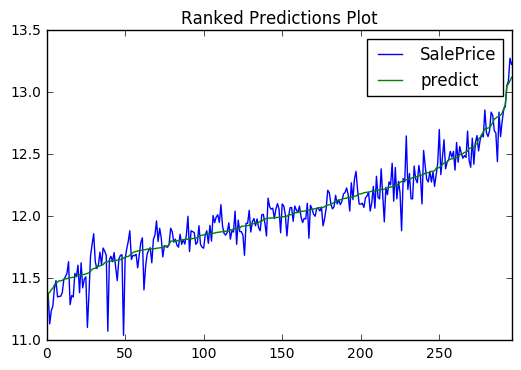

In [22]:
glm2 = glm_grid(encoded_combined_nums, 'SalePrice', base_train, base_valid)

## Train combiner model on second level data

#### Add prediction features to second level data and test data

In [23]:
stack_train = stack_train.cbind(glm0.predict(stack_train))
stack_valid = stack_valid.cbind(glm0.predict(stack_valid))
stack_train = stack_train.cbind(glm1.predict(stack_train))
stack_valid = stack_valid.cbind(glm1.predict(stack_valid))
stack_train = stack_train.cbind(glm2.predict(stack_train))
stack_valid = stack_valid.cbind(glm2.predict(stack_valid))

test = test.cbind(glm0.predict(test))
test = test.cbind(glm1.predict(test))
test = test.cbind(glm2.predict(test))

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: | (failed)


OSError: Job with key $03017f00000132d4ffffffff$_acd6a338d4f4be2f4965bfeec6ee4590 failed with an exception: DistributedException from /127.0.0.1:54321: '24', caused by java.lang.ArrayIndexOutOfBoundsException: 24
stacktrace: 
DistributedException from /127.0.0.1:54321: '24', caused by java.lang.ArrayIndexOutOfBoundsException: 24
	at water.MRTask.getResult(MRTask.java:478)
	at water.MRTask.getResult(MRTask.java:486)
	at water.MRTask.doAll(MRTask.java:390)
	at water.MRTask.doAll(MRTask.java:396)
	at hex.glm.GLMModel.predictScoreImpl(GLMModel.java:1199)
	at hex.Model.score(Model.java:1076)
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:351)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1335)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
Caused by: java.lang.ArrayIndexOutOfBoundsException: 24
	at hex.DataInfo.extractDenseRow(DataInfo.java:1025)
	at hex.glm.GLMScore.map(GLMScore.java:148)
	at water.MRTask.compute2(MRTask.java:657)
	at water.MRTask.compute2(MRTask.java:591)
	at water.MRTask.compute2(MRTask.java:591)
	at water.H2O$H2OCountedCompleter.compute1(H2O.java:1338)
	at hex.glm.GLMScore$Icer.compute1(GLMScore$Icer.java)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1334)
	... 5 more


#### Train stack model

In [ ]:
glm3 = glm_grid(encoded_combined_nums + ['predict', 'predict0', 'predict1'], 'SalePrice', stack_train, stack_valid)

#### Score test data

In [ ]:
sub = test['Id'].cbind(glm3.predict(test))
sub['predict'] = sub['predict'].exp()
print(sub.head())

#### Create submission

In [ ]:
# create time stamp
import re
import time
time_stamp = re.sub('[: ]', '_', time.asctime())

# save file for submission
sub.columns = ['Id', 'SalePrice']
sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
h2o.download_csv(sub, sub_fname)

In [ ]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)